In [1]:
# !pip install 'tensorflow==1.5.0'
# !pip install 'edward==1.3.5'

# Configure env...

In [2]:
# %matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
# import seaborn as sns
import statsmodels.api as sm

import numpy.random as npr
import os
from datetime import *
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from scipy.stats import invgamma
from edward.models import Normal, Gamma, Dirichlet, InverseGamma, \
    Poisson, PointMass, Empirical, ParamMixture, \
    MultivariateNormalDiag, Categorical, Laplace,\
    MultivariateNormalTriL, Bernoulli, TransformedDistribution, \
    Binomial
from edward.util import Progbar
from scipy import sparse, stats
from scipy.special import expit, logit
# from deconfounder_poissonMF import PoissonMF
from sklearn.linear_model import Ridge, LinearRegression
plt.style.use('ggplot')
np.set_printoptions(formatter={'float': lambda x: "{0:0.10f}".format(x)})

# set random seed so everyone gets the same number
import random
import time
randseed = int(time.time())
# random seed for reproducibility
randseed = 1592223649
print("random seed: ", randseed)

random seed:  1592223649


In [3]:
# directory
DATA_PATH = os.path.join(os.getcwd(), 'data')
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Two-cause simulation

In [4]:
class PPCA():


    """

    Parameters
    ----------
    X : numpy array
        patient-causes matrix, count or binary
    K : integer
        number of latent class
    M : integer
        mini-batch size for stochastic optimization. M <= X.shape[1]
    holdout_portion: float
        number of holdout datapoints. Between 0 and 1

    """
    
    def __init__(self, X, K, M, holdout_portion):
        self.X = X
        self.K = K
        self.M = M
        self.holdout_portion = holdout_portion
    # for stochastic optimization
    # subsample genes
    def __next_batch(self, x_train):
        idx_batch = np.random.choice(self.N, self.M)
        return x_train[:, idx_batch], idx_batch
    def __holdout(self):
        # randomly holdout some entries of X
        num_datapoints, data_dim = self.X.shape
        n_holdout = int(self.holdout_portion * num_datapoints * data_dim)

        holdout_row = np.random.randint(num_datapoints, size=n_holdout)
        holdout_col = np.random.randint(data_dim, size=n_holdout)
        holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                                    (holdout_row, holdout_col)), \
                                    shape = self.X.shape)).toarray()
        holdout_mask = np.minimum(holdout_mask, np.ones(self.X.shape))
        holdout_mask = np.float32(holdout_mask)


        holdout_subjects = np.unique(holdout_row)

        x_train = np.multiply(1-holdout_mask, self.X)
        x_vad = np.multiply(holdout_mask, self.X)
        return x_train, x_vad, holdout_row, holdout_col, holdout_mask
    
    def reconstruct_causes(self):
        return self.x_post_np

    def run(self):
        x_train, x_vad, holdout_row, holdout_col, holdout_mask = self.__holdout()
        self.N = x_train.shape[1]  # number of data points
        self.D = x_train.shape[0]  # data dimensionality

        tf.reset_default_graph()
        sess = tf.InteractiveSession()

        # MODEL
        idx_ph = tf.placeholder(tf.int32, self.M)
        x_ph = tf.placeholder(tf.float32, [self.D, self.M])

        w = Normal(loc=0.0, scale=1.0, sample_shape=[self.D, self.K])
        z = Normal(loc=0.0, scale=1.0, sample_shape=[self.M, self.K])
        x = Normal(loc=tf.matmul(w, z, transpose_b=True),
                   scale=stddv_datapoints*tf.ones([self.D, self.M]))

        # INFERENCE
        qw_variables = [tf.Variable(tf.random_normal([self.D, self.K])),
                        tf.Variable(tf.random_normal([self.D, self.K]))]

        qw = Normal(loc=qw_variables[0], scale=tf.nn.softplus(qw_variables[1]))

        qz_variables = [tf.Variable(tf.random_normal([self.N, self.K])),
                        tf.Variable(tf.random_normal([self.N, self.K]))]

        qz = Normal(loc=tf.gather(qz_variables[0], idx_ph),
                    scale=tf.nn.softplus(tf.gather(qz_variables[1], idx_ph)))

        inference_w = ed.KLqp({w: qw}, data={x: x_ph, z: qz})
        inference_z = ed.KLqp({z: qz}, data={x: x_ph, w: qw})

        scale_factor = float(self.N) / self.M
        inference_w.initialize(scale={x: scale_factor, z: scale_factor},
                               var_list=qz_variables,
                               n_samples=5, n_iter=2000)
        inference_z.initialize(scale={x: scale_factor, z: scale_factor},
                               var_list=qw_variables,
                               n_samples=5)

        sess = ed.get_session()
        tf.global_variables_initializer().run()
        loss = []
        for _ in range(inference_w.n_iter):
            x_batch, idx_batch = self.__next_batch(x_train)
            for _ in range(5):
                inference_z.update(feed_dict={x_ph: x_batch, \
                                              idx_ph: idx_batch})

            info_dict = inference_w.update(feed_dict={x_ph: x_batch, \
                                                      idx_ph: idx_batch})
            inference_w.print_progress(info_dict)

            t = info_dict['t']
            loss.append(info_dict['loss'])
        pd.Series(loss).plot()
        
        w_post = Normal(loc=qw_variables[0], scale=tf.nn.softplus(qw_variables[1]))
        z_post = Normal(loc=qz_variables[0],
                    scale=tf.nn.softplus(qz_variables[1]))
        x_post = Normal(loc=tf.matmul(w_post, z_post, transpose_b=True),
                   scale=stddv_datapoints*tf.ones([self.D, self.N]))

        
        n_rep = 100 # number of replicated datasets we generate
        holdout_gen = np.zeros((n_rep, x_train.shape[0], x_train.shape[1]))

        for i in range(n_rep):
            x_generated = x_post.sample().eval()

            # look only at the heldout entries
            holdout_gen[i] = np.multiply(x_generated, holdout_mask)

        n_eval = 10 # we draw samples from the inferred Z and W
        obs_ll = []
        rep_ll = []
        for j in range(n_eval):
            w_sample = w_post.sample().eval()
            z_sample = z_post.sample().eval()

            holdoutmean_sample = np.multiply(w_sample.dot(z_sample.T), holdout_mask)
            obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                                stddv_datapoints).logpdf(x_vad), axis=0))

            rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                                stddv_datapoints).logpdf(holdout_gen),axis=1))

        obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)

        pvals = np.array([np.mean(rep_ll_per_zi[:,i] < obs_ll_per_zi[i]) for i in range(len(obs_ll_per_zi))])
        holdout_subjects = np.unique(holdout_col)
        self.overall_pval = np.mean(pvals[holdout_subjects])
        print("Predictive check p-values for K={}".format(self.K), self.overall_pval)

        #results
        # Ahat and Zhat in the paper
        self.x_post_np = x_post.mean().eval()

In [5]:
random.seed(randseed)
np.random.seed(randseed)
tf.set_random_seed(randseed)


Nsim = 500 #num of simulations
N = 1000 #num of datapoints
A = np.zeros((N, 2))

C = np.random.normal(0,1, size = N)# confounder

A[:,0] = 0.3*C + np.random.normal(0,1, size = N) # cause 1
A[:,1] = 0.4*C + np.random.normal(0,1, size = N) # cause 2

# scenario 1: no real cause
true_coeffs1 = [0.0,0.0,0.5]
Y1 = np.dot(A, true_coeffs1[:2]) + true_coeffs1[2]*C + np.random.normal(0,1, size = [Nsim, N])

# scenario 2: one real cause
true_coeffs2 = [0.0,0.3,0.5]
Y2 = np.dot(A, true_coeffs2[:2]) + true_coeffs2[2]*C + np.random.normal(0,1, size = [Nsim, N])


# standardize the data for PPCA
for s in range(Nsim):
    A = (A - A.mean(axis=0))/A.std(axis=0)

2000/2000 [100%] ██████████████████████████████ Elapsed: 23s | Loss: 3228.169
Predictive check p-values for K=1 0.4710942249240122


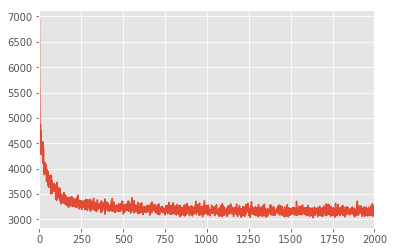

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
random.seed(randseed)
np.random.seed(randseed)
tf.set_random_seed(randseed)


stddv_datapoints = 1.0
K=1

ppca = PPCA(A.T, K, 100, 0.2)
ppca.run()
x_post_np = ppca.reconstruct_causes()

# Outcome model

## Scenario 1: no real cause

In [7]:
np.set_printoptions(precision=4)
# Oracle
X_aug = np.column_stack([A, C])
X = sm.add_constant(X_aug)
coeffs = []
stderr = []
pvalues = []
for s in range(Nsim):
    model = sm.OLS(Y1[s, :].T, X)
    res = model.fit()
    coeffs.append(res.params[1:3])
    stderr.append(res.bse[1:3])
    pvalues.append(res.pvalues[1:3])
    
coeffs = np.array(coeffs)
t2, p2 = stats.ttest_1samp(coeffs,0)
print("Oracle")
print ("Coeff: ", coeffs.mean(axis=0), "Std err: ", np.mean(stderr, axis=0), "p-value: ", np.mean(pvalues, axis=0))

# Unadjusted
X = sm.add_constant(A)
coeffs = []
stderr = []
pvalues = []
for s in range(Nsim):
    model = sm.OLS(Y1[s, :].T, X)
    res = model.fit()
    coeffs.append(res.params[1:3])
    stderr.append(res.bse[1:3])
    pvalues.append(res.pvalues[1:3])
    
coeffs = np.array(coeffs)
t2, p2 = stats.ttest_1samp(coeffs,0)
print("Unadjusted")
print ("Coeff: ", coeffs.mean(axis=0), "Std err: ", np.mean(stderr, axis=0), "p-value: ", np.mean(pvalues, axis=0))


# Adjusted
X_aug = np.column_stack([A, x_post_np.T])
X = sm.add_constant(X_aug)
coeffs = []
stderr = []
pvalues = []
for s in range(Nsim):
    model = sm.OLS(Y1[s, :].T, X)
    res = model.fit()
    coeffs.append(res.params[1:3])
    stderr.append(res.bse[1:3])
    pvalues.append(res.pvalues[1:3])
    
coeffs = np.array(coeffs)
t2, p2 = stats.ttest_1samp(coeffs,0)
print("Med. Dcf")
print ("Coeff: ", coeffs.mean(axis=0), "Std err: ", np.mean(stderr, axis=0), "p-value: ", np.mean(pvalues, axis=0))

Oracle
Coeff:  [0.0021 0.0017] Std err:  [0.0332 0.0343] p-value:  [0.5059 0.5009]
Unadjusted
Coeff:  [0.1252 0.1768] Std err:  [0.035 0.035] p-value:  [0.0085 0.0002]
Med. Dcf
Coeff:  [0.1003 0.146 ] Std err:  [0.0555 0.0626] p-value:  [0.1768 0.0836]


## Scenario 2: one real cause

In [8]:
np.set_printoptions(precision=4)
# Oracle
X_aug = np.column_stack([A, C])
X = sm.add_constant(X_aug)
coeffs = []
stderr = []
pvalues = []
for s in range(Nsim):
    model = sm.OLS(Y2[s, :].T, X)
    res = model.fit()
    coeffs.append(res.params[1:3])
    stderr.append(res.bse[1:3])
    pvalues.append(res.pvalues[1:3])
    
coeffs = np.array(coeffs)
t2, p2 = stats.ttest_1samp(coeffs,0)
print("Oracle")
print ("Coeff: ", coeffs.mean(axis=0), "Std err: ", np.mean(stderr, axis=0), "p-value: ", np.mean(pvalues, axis=0))

# Unadjusted
X = sm.add_constant(A)
coeffs = []
stderr = []
pvalues = []
for s in range(Nsim):
    model = sm.OLS(Y2[s, :].T, X)
    res = model.fit()
    coeffs.append(res.params[1:3])
    stderr.append(res.bse[1:3])
    pvalues.append(res.pvalues[1:3])
    
coeffs = np.array(coeffs)
t2, p2 = stats.ttest_1samp(coeffs,0)
print("Unadjusted")
print ("Coeff: ", coeffs.mean(axis=0), "Std err: ", np.mean(stderr, axis=0), "p-value: ", np.mean(pvalues, axis=0))


# Adjusted
X_aug = np.column_stack([A, x_post_np.T])
X = sm.add_constant(X_aug)
coeffs = []
stderr = []
pvalues = []
for s in range(Nsim):
    model = sm.OLS(Y2[s, :].T, X)
    res = model.fit()
    coeffs.append(res.params[1:3])
    stderr.append(res.bse[1:3])
    pvalues.append(res.pvalues[1:3])
    
coeffs = np.array(coeffs)
t2, p2 = stats.ttest_1samp(coeffs,0)
print("Med. Dcf")
print ("Coeff: ", coeffs.mean(axis=0), "Std err: ", np.mean(stderr, axis=0), "p-value: ", np.mean(pvalues, axis=0))

Oracle
Coeff:  [0.0019 0.3262] Std err:  [0.0332 0.0343] p-value:  [0.5105 0.    ]
Unadjusted
Coeff:  [0.1258 0.5025] Std err:  [0.0351 0.0351] p-value:  [0.007 0.   ]
Med. Dcf
Coeff:  [0.0997 0.4704] Std err:  [0.0556 0.0626] p-value:  [0.1625 0.    ]
